# Analyze using Logistic Regression & Feed Forward Neural Network

In [18]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# Local imports
import project_path
from model_logging.logging_config import logger

In [21]:
MAX_SEQ_LENGTH = 128
BERT_MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3

In [19]:
# 1. Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Starting Logistic Regression & Feed Forward Neural Network: using device {device}")

2025-12-13 14:50:57,892 - INFO - Starting Logistic Regression & Feed Forward Neural Network: using device cuda


In [22]:
logger.info("Initialize tokenizer using BERT 768-dimensional model.")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

2025-12-13 14:51:31,173 - INFO - Initialize tokenizer using BERT 768-dimensional model.


In [28]:
logger.info("Loading balanced email dataset from feather file.")
email_dataframe = pd.read_feather("../../../data/3_balanced_email_dataset.feather")

2025-12-13 14:53:00,060 - INFO - Loading balanced email dataset from feather file.


In [8]:
class EmailDataset(Dataset):
    """A custom PyTorch Dataset class for handling the email text and labels."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and encode the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,       # Add [CLS] and [SEP]
            max_length=self.max_len,       # Pad/truncate to max_len
            return_token_type_ids=False,   # Not needed for simple classification
            padding='max_length',          # Pad to max_len
            truncation=True,               # Truncate if longer than max_len
            return_attention_mask=True,    # Return attention mask
            return_tensors='pt',           # Return PyTorch tensors
        )

        # Return a dictionary containing the necessary tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
logger.info("Encode labels into a numerical format.")
email_dataframe.sample(frac=1).reset_index(drop=True)

# 3. Label Encoding
# Map 'ham', 'spam', 'phish' to 0, 1, 2
label_encoder = LabelEncoder()
email_dataframe['Label_ID'] = label_encoder.fit_transform(email_dataframe['Email Type'])
NUM_CLASSES = len(label_encoder.classes_) # Should be 3
CLASS_NAMES = label_encoder.classes_
logger.info(f"Classes encoded: {CLASS_NAMES}")

logger.info("Split using 0.9 train and 0.1 test sets. Prepare DataLoaders")
X_train, X_test, y_train, y_test = train_test_split(
    email_dataframe['Email Text'].to_numpy(),
    email_dataframe['Label_ID'].to_numpy(),
    test_size=0.1,
    random_state=42
)

train_dataset = EmailDataset(
    texts=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_SEQ_LENGTH
)

test_dataset = EmailDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_SEQ_LENGTH
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [10]:
class EmailClassifier(nn.Module):
    """
    BERT-based classifier with a single linear classification head.
    This structure implements the multi-class logistic regression requirement.
    """
    def __init__(self, num_classes, bert_model_name):
        super(EmailClassifier, self).__init__()

        # Load BERT encoder
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Classification Head: Linear layer (the core of Logistic Regression)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Pass inputs through BERT
        outputs = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            return_dict=False # We use the positional output for simplicity
        )

        # Get the hidden state of the [CLS] token (first token)
        cls_token_output = outputs[0][:, 0, :]

        # Pass the [CLS] vector through the final linear layer to get logits
        logits = self.classifier(cls_token_output)

        return logits

In [11]:
# --- Training Function ---
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    """Performs a single training epoch."""
    model = model.train()
    losses = []

    for batch in data_loader:
        # Move batch data to the target device (CUDA/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward Pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate Loss
        loss = loss_fn(logits, labels)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping for stability
        optimizer.step()

    return np.mean(losses)

In [12]:

# --- Initialization and Execution ---

# Instantiate the model and move it to the GPU
model = EmailClassifier(
    num_classes=NUM_CLASSES, 
    bert_model_name=BERT_MODEL_NAME
)
model.to(device)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss().to(device) # Loss function should also be on the device
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(
        model, 
        train_loader, 
        criterion, 
        optimizer, 
        device
    )
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training Loss: {train_loss:.4f}")
    
print("\nTraining complete!")
# Now you would typically call an evaluation function (not shown here)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Starting Training...
Epoch 1/3 - Training Loss: 0.1788
Epoch 2/3 - Training Loss: 0.0715
Epoch 3/3 - Training Loss: 0.0418

Training complete!


In [15]:
def eval_model(model, data_loader, loss_fn, device):
    """
    Performs evaluation and collects true labels and predictions for the confusion matrix.
    """
    model = model.eval()
    losses = []
    correct_predictions = 0

    # Lists to store all true labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            losses.append(loss.item())

            # Find the predicted class index
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            # Store results for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = np.mean(losses)
    accuracy = correct_predictions.double() / len(data_loader.dataset)

    return avg_loss, accuracy.item(), all_labels, all_preds

In [25]:
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "../models/logit_reg_ff_nn.joblib")

['../models/logit_reg_ff_nn.joblib']

In [ ]:
final_loss, final_accuracy, true_labels, predictions = eval_model(
    model,
    test_loader,
    criterion,
    device
)

In [29]:
report = classification_report(
    true_labels, 
    predictions, 
    target_names=CLASS_NAMES, 
    digits=4
)
logger.info(report)
print(report)

NameError: name 'true_labels' is not defined

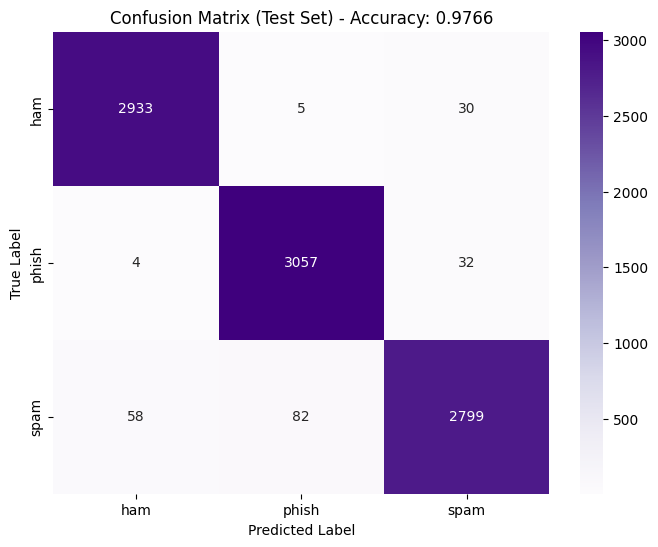


--- Final Results ---
Final Test Accuracy: 0.9766
Confusion Matrix (Raw Counts):
 [[2933    5   30]
 [   4 3057   32]
 [  58   82 2799]]

Class Order (0, 1, 2): ['ham' 'phish' 'spam']


In [26]:
# 1. Compute the Confusion Matrix
# Rows = True Labels, Columns = Predicted Labels
cm = confusion_matrix(true_labels, predictions)

# 2. Display the Confusion Matrix (using matplotlib and seaborn for clarity)
plt.figure(figsize=(8, 6))
# 
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Purples",
    xticklabels=CLASS_NAMES, 
    yticklabels=CLASS_NAMES
)
plt.title(f'Confusion Matrix (Test Set) - Accuracy: {final_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Final Results ---")
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("Confusion Matrix (Raw Counts):\n", cm)

# Helper to interpret the matrix (Ham=0, Phish=1, Spam=2 based on our dummy data)
# Note: The order of classes in CLASS_NAMES depends on the LabelEncoder.fit() step.
print(f"\nClass Order (0, 1, 2): {CLASS_NAMES}")

In [ ]:
# A hypothetical line showing how you would save the model after training:
# torch.save(model.state_dict(), 'email_classifier_bert.pth')

# To load the model:
# 1. Instantiate the model class (same as before)
inference_model = EmailClassifier(num_classes=NUM_CLASSES, bert_model_name=BERT_MODEL_NAME)

# 2. Load the saved weights
# NOTE: In our previous script, the 'model' variable holds the trained weights, 
# so we will use that directly for demonstration. In a production environment, 
# you would load the .pth file.
# inference_model.load_state_dict(torch.load('email_classifier_bert.pth')) 

# 3. Move the model to the target device
inference_model.to(device)

# 4. Set the model to evaluation mode
inference_model.eval()

def classify_email(text, model, tokenizer, label_encoder, device, max_len=128):
    """
    Tokenizes a single text, performs a forward pass through the model, 
    and returns the predicted class name.
    """
    # 1. Input Preparation (Same as Training)
    # The tokenizer must be the exact one used during training.
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt', # Returns PyTorch tensor
    )
    
    # 2. Move Tensors to Device (CUDA)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # 3. Forward Pass (Inference)
    with torch.no_grad():
        # Pass data through the trained model
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # 4. Softmax and Prediction
        # Apply Softmax to convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)
        
        # Get the predicted class index (the one with the highest probability)
        predicted_index = torch.argmax(probabilities, dim=1).cpu().item()
        
        # Get the confidence score for the predicted class
        confidence = probabilities[0, predicted_index].cpu().item()

    # 5. Decode Numerical Prediction
    # Use the label_encoder to convert the numerical ID back to the class name
    predicted_class_name = label_encoder.inverse_transform([predicted_index])[0]
    
    return predicted_class_name, confidence, probabilities.cpu().numpy().flatten()

In [ ]:
# Define a few new emails for classification
new_emails = [
    "Your recent order has shipped. Tracking number: 1A2B3C.", # Ham
    "URGENT: Your PayPal account has been compromised. Log in immediately at http://evil-site.com/login", # Phish
    "FREE V!AGRA and Cialis delivered overnight.", # Spam
    "Please send the report by the end of the day." # Ham
]

# Use the 'model' and 'label_encoder' from the previous training run
# (Assuming the training script has been executed and these variables exist)

print("\n--- Classifying New Emails ---")
for i, email in enumerate(new_emails):
    
    # Perform classification
    predicted_class, confidence, all_probs = classify_email(
        email, 
        model, 
        tokenizer, 
        label_encoder, 
        device, 
        MAX_SEQ_LENGTH
    )
    
    # Get the class names in the order of the probability array (e.g., Ham, Phish, Spam)
    class_probs = dict(zip(CLASS_NAMES, all_probs))
    
    print(f"\nEmail {i+1}: '{email[:50]}...'")
    print(f"  Prediction: **{predicted_class.upper()}** (Confidence: {confidence:.4f})")
    print(f"  Probabilities: {class_probs}")